In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [32]:

# Define the feature extractor (f)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 7 * 7, 128)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Define the classification head (θ)
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Synthesizer: A simple generator for model inversion
class Synthesizer(nn.Module):
    def __init__(self, feature_dim, image_shape):
        super(Synthesizer, self).__init__()
        self.fc = nn.Linear(feature_dim, np.prod(image_shape))
        self.image_shape = image_shape

    def forward(self, features):
        images = self.fc(features).view(-1, *self.image_shape)
        return torch.sigmoid(images)  # Generate synthetic images


In [33]:
def create_mnist_data(num_classes, task_index,csv_file="mnist.csv", image_shape=(1, 28, 28)):
    mnist_file = open(csv_file)
    df = pd.read_csv(mnist_file)

    # Determine the classes for this task
    all_classes = sorted(df['label'].unique())  # Get all unique classes
    start_class = task_index * num_classes      # Starting class for this task
    end_class = start_class + num_classes       # Ending class for this task
    valid_classes = all_classes[start_class:end_class]

    # Filter the dataset for the valid classes
    filtered_df = df[df['label'].isin(valid_classes)]

    # Separate features and labels
    X = filtered_df.drop(columns=['label']).values  # Features (flattened images)
    y = filtered_df['label'].values                # Labels

    # Normalize and reshape the images
    X = torch.tensor(X / 255.0, dtype=torch.float32)  # Normalize to [0, 1]
    X = X.view(-1, *image_shape)  # Reshape to (batch, 1, 28, 28)
    y = torch.tensor(y, dtype=torch.long)            # Convert labels to tensors

    return TensorDataset(X, y)

In [119]:

# Knowledge distillation loss
def knowledge_distillation_loss(pred, target, temperature=2):
    soft_pred = F.log_softmax(pred / temperature, dim=1)
    soft_target = F.softmax(target / temperature, dim=1)
    return F.kl_div(soft_pred, soft_target, reduction="batchmean") * (temperature ** 2)


# Training loop with progress bars
def train_r_dfcil(task_data, num_classes_per_task, feature_dim=128, image_shape=(1, 28, 28), epochs=3):
    feature_extractor = FeatureExtractor()
    classification_head = ClassificationHead(feature_dim, num_classes_per_task[0])
    synthesizer = Synthesizer(feature_dim, image_shape)

    old_model = None
    optimizer = optim.Adam(list(feature_extractor.parameters()) + list(classification_head.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for task_idx, (train_data, test_data) in enumerate(task_data):
        print(f"\nTraining on Task {task_idx + 1}/{len(task_data)}")
        train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
        num_classes = sum(num_classes_per_task[:task_idx + 1])

        if task_idx > 0:
            # Expand the classification head for new classes
            old_classification_head = classification_head
            classification_head = ClassificationHead(feature_dim, num_classes)
            classification_head.fc.weight.data[:old_classification_head.fc.out_features] = \
                old_classification_head.fc.weight.data
            classification_head.fc.bias.data[:old_classification_head.fc.out_features] = \
                old_classification_head.fc.bias.data

        # Optimizer for expanded model
        optimizer = optim.Adam(list(feature_extractor.parameters()) + list(classification_head.parameters()), lr=0.001)

        # Train synthesizer using the old model
        if old_model is not None:
            print("Training synthesizer...")
            synth_optimizer = optim.Adam(synthesizer.parameters(), lr=0.001)
            for epoch in tqdm(range(epochs), desc="Synthesizer Training", leave=False):
                features = torch.randn(32, feature_dim)  # Random latent features
                synthetic_images = synthesizer(features)
                synth_optimizer.zero_grad()
                features = old_model[0](synthetic_images)
                preds = old_model[1](features)
                loss = criterion(preds, torch.randint(0, num_classes - num_classes_per_task[task_idx], (32,)))
                loss.backward()
                synth_optimizer.step()

        # Train new task
        print("Training model...")
        for epoch in tqdm(range(epochs), desc=f"Task {task_idx + 1} Training", leave=False):
            feature_extractor.train()
            classification_head.train()
            epoch_loss = 0
            for images, labels in train_loader:
                images, labels = images, labels
                optimizer.zero_grad()

                # Forward pass
                features = feature_extractor(images)
                outputs = classification_head(features)

                # Loss calculation
                loss = criterion(outputs, labels)

                # Add knowledge distillation loss if old model exists
                if old_model is not None:
                    with torch.no_grad():
                        old_features = old_model[0](images)
                        old_outputs = old_model[1](old_features)
                    loss += knowledge_distillation_loss(outputs[:, :num_classes - num_classes_per_task[task_idx]],
                                                        old_outputs)

                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            tqdm.write(f"Epoch {epoch + 1}/{epochs} Loss: {epoch_loss / len(train_loader):.4f}")

        # Freeze old model
        old_model = (feature_extractor, classification_head)
        print(f"Finished Task {task_idx + 1}/{len(task_data)}")
    return feature_extractor, classification_head, synthesizer



In [120]:
num_classes_per_task = [5, 5]  # Task 1: 5 classes, Task 2: 5 classes
image_shape = (1, 28, 28)

# Load MNIST datasets for tasks
task1_data = create_mnist_data(num_classes_per_task[0], task_index=0, image_shape=image_shape)
task2_data = create_mnist_data(num_classes_per_task[1], task_index=1, image_shape=image_shape)
data = create_mnist_data(10, task_index=0, image_shape=image_shape)

# Prepare task data
task_data = [(task1_data, task1_data), (task2_data, task2_data)]  # (train, test)

# Train R-DFCIL
feature_extractor, classification_head, synthesizer = train_r_dfcil(task_data, num_classes_per_task, image_shape=image_shape)


Training on Task 1/2
Training model...


Task 1 Training:  33%|███▎      | 1/3 [00:25<00:50, 25.30s/it]

Epoch 1/3 Loss: 0.0934


Task 1 Training:  67%|██████▋   | 2/3 [00:50<00:25, 25.53s/it]

Epoch 2/3 Loss: 0.0251


Epoch 3/3 Loss: 0.0158
Finished Task 1/2

Training on Task 2/2
Training synthesizer...


Training model...


Task 2 Training:  33%|███▎      | 1/3 [00:33<01:06, 33.26s/it]

Epoch 1/3 Loss: 0.1419


Task 2 Training:  67%|██████▋   | 2/3 [01:07<00:33, 33.82s/it]

Epoch 2/3 Loss: 0.0316


Epoch 3/3 Loss: 0.0201
Finished Task 2/2


In [123]:
def inference_on_model(feature_extractor, classification_head, loader, num_classes):
    feature_extractor.eval()
    classification_head.eval()

    all_preds = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_extractor.to(device)
    classification_head.to(device)

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)

            # Ensure images have the correct batch and channel dimensions
            if len(images.shape) == 3:  # If shape is (batch, height, width)
                images = images.unsqueeze(1)  # Add channel dimension (batch, channels, height, width)

            # Forward pass
            features = feature_extractor(images)
            logits = classification_head(features)
            predictions = torch.argmax(logits, dim=1)

            # Collect results for evaluation
            all_preds.extend(predictions.cpu().numpy())

            # Reshape labels to match batch processing
            if labels.ndimension() == 0:  # If labels are 0-dimensional (scalar)
                labels = labels.unsqueeze(0)

            all_labels.extend(labels.cpu().numpy())

            # Occasionally display predictions
            if batch_idx % 2000 == 0:  # Adjust frequency as needed
                print(f"Batch {batch_idx} Predictions:")
                print(f"Predicted: {predictions.cpu().numpy()}")
                print(f"True:      {labels.cpu().numpy()}")

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(num_classes)),
                yticklabels=list(range(num_classes)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(cm)


Batch 0 Predictions:
Predicted: [1]
True:      [1]
Batch 2000 Predictions:
Predicted: [9]
True:      [3]
Batch 4000 Predictions:
Predicted: [8]
True:      [8]
Batch 6000 Predictions:
Predicted: [7]
True:      [1]
Batch 8000 Predictions:
Predicted: [8]
True:      [8]
Batch 10000 Predictions:
Predicted: [8]
True:      [2]
Batch 12000 Predictions:
Predicted: [7]
True:      [7]
Batch 14000 Predictions:
Predicted: [6]
True:      [6]
Batch 16000 Predictions:
Predicted: [8]
True:      [1]
Batch 18000 Predictions:
Predicted: [7]
True:      [7]
Batch 20000 Predictions:
Predicted: [8]
True:      [3]
Batch 22000 Predictions:
Predicted: [7]
True:      [7]
Batch 24000 Predictions:
Predicted: [7]
True:      [4]
Batch 26000 Predictions:
Predicted: [7]
True:      [1]
Batch 28000 Predictions:
Predicted: [5]
True:      [3]
Batch 30000 Predictions:
Predicted: [8]
True:      [3]
Batch 32000 Predictions:
Predicted: [6]
True:      [6]
Batch 34000 Predictions:
Predicted: [7]
True:      [1]
Batch 36000 Predic

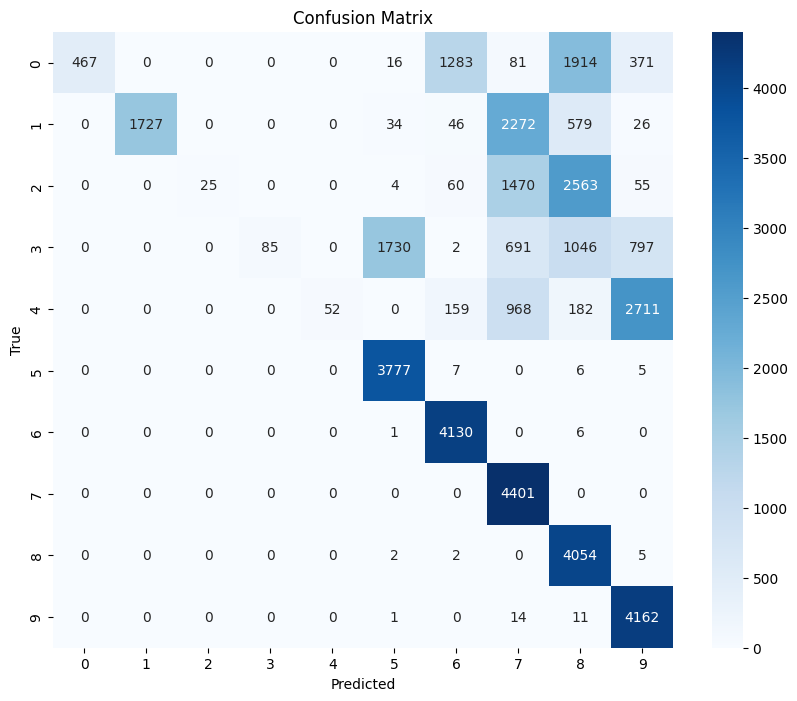

[[ 467    0    0    0    0   16 1283   81 1914  371]
 [   0 1727    0    0    0   34   46 2272  579   26]
 [   0    0   25    0    0    4   60 1470 2563   55]
 [   0    0    0   85    0 1730    2  691 1046  797]
 [   0    0    0    0   52    0  159  968  182 2711]
 [   0    0    0    0    0 3777    7    0    6    5]
 [   0    0    0    0    0    1 4130    0    6    0]
 [   0    0    0    0    0    0    0 4401    0    0]
 [   0    0    0    0    0    2    2    0 4054    5]
 [   0    0    0    0    0    1    0   14   11 4162]]


In [124]:
inference_on_model(feature_extractor,classification_head,data,10)

In [88]:
def infer(f, c, loader, index):
    f.eval()
    c.eval()
    all_preds = []
    all_label = []
    img,label = loader[index]
    features = f(img.unsqueeze(0))
    logits = c(features)
    predictions = torch.argmax(logits, dim=1)
    plt.imshow(img.squeeze(0), cmap='gray')
    plt.show()
    print(f"Predicted: {predictions.cpu().numpy()}")
    print(f"True:      {label.cpu().numpy()}")


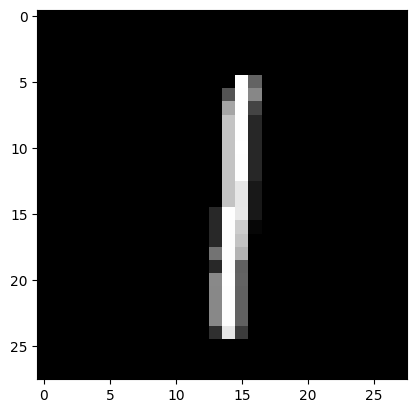

Predicted: [1]
True:      1


In [76]:
infer(feature_extractor,classification_head,task1_data, 20000 )

In [93]:
features = torch.randn(32, 128)
synthetic_images = synthesizer(features)

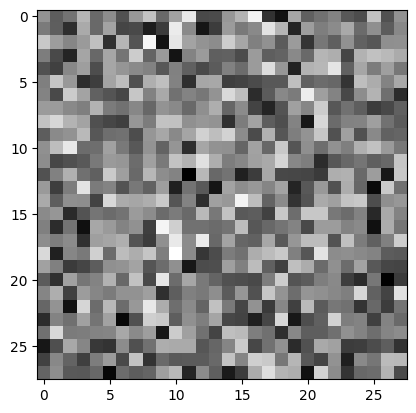

In [104]:
plt.imshow(synthetic_images[0][0].detach(), cmap='gray')
plt.show()